<a href="https://colab.research.google.com/github/EziamaUgonna/Bayesian_analysis-/blob/master/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tf-nightly-gpu-2.0-preview tfp-nightly
!pip install --upgrade -q gspread
from tensorboardcolab import *
import shutil
#clean out the directory
shutil.rmtree('./Graph', ignore_errors=True)
os.mkdir('./Graph')
#tf.reset_default_graph()
#will start the tunneling and will print out a link:
tbc=TensorBoardColab()


Requirement already up-to-date: tf-nightly-gpu-2.0-preview in /usr/local/lib/python3.6/dist-packages (2.0.0.dev20190603)
Requirement already up-to-date: tfp-nightly in /usr/local/lib/python3.6/dist-packages (0.8.0.dev20190603)


Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://3d262dce.ngrok.io


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals 

In [3]:
# Dependencies
import os 
import warnings 
#from absl import flags 
import matplotlib 
import numpy as np 
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from __future__ import absolute_import, division, print_function, unicode_literals
#from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
#import python_utils
import tensorflow as tf 
import tensorflow_probability as tfp
tfd = tfp.distributions
#from tutorial
print("tf_version: ",tf.__version__)
print("tfp_version: ", tfp.__version__)

tf_version:  2.0.0-dev20190603
tfp_version:  0.8.0-dev20190603


In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# Read in the dataset
df = pd.read_csv('/content/gdrive/My Drive/work2.csv').astype(np.float32)
change = df.query('Speed>0').sample(frac = .1).index
df.loc[change, 'Speed'] = 0
df.loc[change, 'Class'] = 0
df.to_csv('work2.csv', header = True, index =False)
df.shape

df.columns

Index(['RxDevice', 'FileID', 'TxDevice', 'Gentime', 'TxRandom', 'MsgCount',
       'Dsecond', 'Latitude', 'Longitude', 'Elevation', 'Speed', 'Heading',
       'Ax', 'Ay', 'Az', 'Yawrate', 'PathCount', 'RadiusOfCurve', 'Confidence',
       'Class'],
      dtype='object')

In [0]:
df_train, df_test = train_test_split(df, test_size=0.25)


X = df_train.iloc[:,:-1].values
y = df_train.iloc[:,-1].values

In [0]:
original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

In [0]:
#Computation of Prior 
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)


In [9]:
!pwd

/content


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8)                 698       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20)                334       
____________________________________________

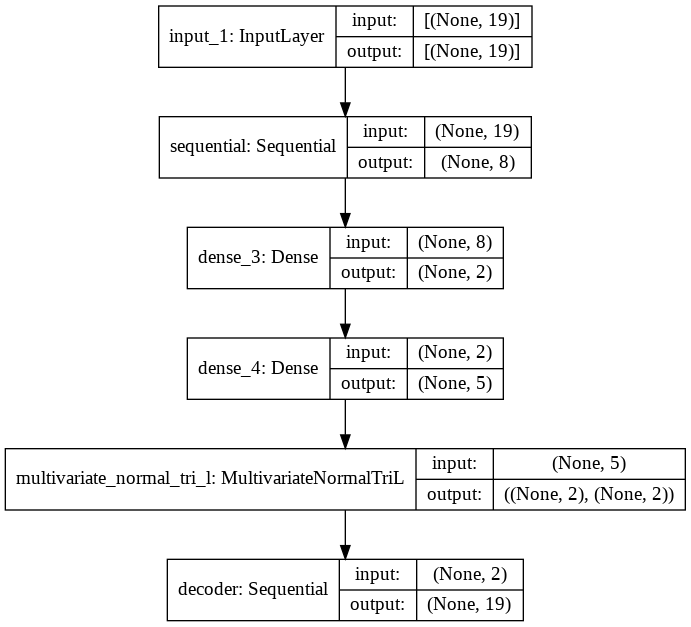

In [10]:


def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    dense_layers(intermediary_dims),
    tfkl.Dense(latent_dim, activation = tf.nn.leaky_relu),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim,activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
], name='encoder')

from keras.utils import plot_model
#plot model error 
#check https://github.com/tensorflow/tensorflow/pull/24625
encoder.summary()
tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
tf.keras.utils.plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss=negloglik)

vae.summary()
tf.keras.utils.plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

In [0]:
#x_norm, x_fraud = X.values[y == 0], X.values[y == 1]
x_norm, x_fraud = X[y == 0], X[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)


In [0]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

In [0]:
#callbacks_list = [tf.keras.callbacks.ModelCheckpoint (filepath='bestmodel.h5', verbose=0, save_best_only=True),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005,  patience=20, verbose=0, restore_best_weights=True)]

"""callbacks_list = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
patience=1,
)"""




checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='vae.weights.best.hdf5', verbose=0, save_best_only=True)




earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)



history = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer])





In [0]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [0]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
ax = plt.hist([x_log_prob[Y==0], x_log_prob[Y==1]], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

In [0]:
fpr, tpr, thresh = roc_curve(Y, -x_log_prob)
auc = roc_auc_score(Y, -x_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

VAE Vs SVM 
Let's compare this with trivial supervised SVM classifier. 

In [0]:
from sklearn import svm 
clf =svm.SVC(gamma ='scale')
clf.fit(X,Y)
auc = roc_auc_score(Y, clf.predict(X))
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

Evaluation on Test Set 

In [0]:
x_test_log_prob = reconstruction_log_prob(data_test.drop(['Class'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["Class"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

In [0]:
# 

In [0]:
from tensorflow.keras import layers

import numpy as np
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve



In [0]:
# create the training datasets
dx_train = tf.data.Dataset.from_tensor_slices(X_train)
# apply a one-hot transformation to each label for use in the neural network
dy_train = tf.data.Dataset.from_tensor_slices(y_train)
# zip the x and y training data together and shuffle, batch etc.
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500).repeat().batch(8)

In [0]:
# do the same operations for the validation set
dx_valid = tf.data.Dataset.from_tensor_slices(X_test)
dy_valid = tf.data.Dataset.from_tensor_slices(y_test)
valid_dataset = tf.data.Dataset.zip((dx_valid, dy_valid)).shuffle(500).repeat().batch(30)

In [0]:
def mlp_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=X_train.shape[1]),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.SGD(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
    return model
model1 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model2 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model3 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model4 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
ensemble_clf = VotingClassifier(estimators=[
    ('model1', model1), ('model2', model2), ('model3', model3),('model4', model4)])

In [0]:
ensemble_clf.fit(train_dataset, epochs =100, steps_per_epoch=1000, validation_steps =3)

In [0]:
y_predict = ensemble_clf.predict(X_test)
print('acc: ', accuracy_scoreecuracy_scorecuracy_score(y_pred, y_test))